# In-depth Model Fitting
This notebook demonstrates how calibration models can be fitted with the helper function `calibr8.fit_scipy`.

In [29]:
from matplotlib import pyplot
import numpy
import pandas
import scipy.stats

import calibr8

## Generating fake data
For the purpose of this notebook, a synthetic dataset is sufficient.
The parameter vector of the ground truth model consists of two parts: $\theta_µ$ and $\theta_\sigma$.

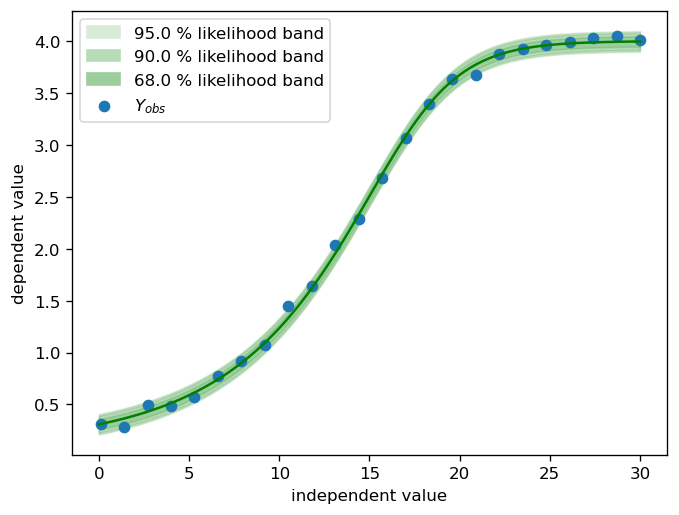

In [30]:
θ_mu = (0.1, 4, 15, 0.3, 1) # 5 parameters of the asymmetric logistic
θ_scale = (0.05,)           # 1 parameter for constant scale
# concatenate all the parameter into one vector:
θ_true = θ_mu + θ_scale

# generate 24 calibration points with normal distributed noise
X = numpy.linspace(0.1, 30, 24)
Y = scipy.stats.norm.rvs(
    loc=calibr8.asymmetric_logistic(X, θ_mu),
    scale=calibr8.polynomial(X, θ_scale),
)

fig, ax = pyplot.subplots(dpi=120)

# plot the noise band of the ground truth
X_dense = numpy.linspace(0, 30, 100)
calibr8.plot_norm_band(
    ax,
    X_dense,
    mu=calibr8.asymmetric_logistic(X_dense, θ_mu),
    scale=calibr8.polynomial(X_dense, θ_scale),
)

ax.scatter(X, Y, label='$Y_{obs}$')

ax.set_xlabel('independent value')
ax.set_ylabel('dependent value')
ax.legend()
pyplot.show()

## Setting up the model
Our data follows an asymmetric logistic ground truth with normal-distributed observation noise.
The noise `sigma` is constant, so it can be modeled with a 0th-degree polynomial.

`calibr8` already implements three commonly used model types that can be inherited and customized:
+ `calibr8.BaseModelN` implements likelihood and inference methods for normal-distributed noise models
+ `calibr8.BasePolynomialModelN` models `mu` and `sigma` as polynomials
+ `calibr8.BaseAsymmetricLogisticModelN` models `mu` as asymmetric logistic and `sigma` as polynomial
The degress of the polynomials in `BasePolynomialModelN` and `BaseAsymmetricLogisticModelN` are user-defined.

In [31]:
class ToyAsymmetricModelV1(calibr8.BaseAsymmetricLogisticN):
    def __init__(self):
        super().__init__(
            independent_key='concentration_mM',
            dependent_key='absorbance_au',
            sigma_degree=0
        )

## Fitting
Here we will not only fit the model, but also compare the two available fitting methods.

We begin by making initial guesses about $\theta$ and the bounds of the parameter space.

The best way to make initial guesses is to scatter-plot the raw data and visually guess the limits, inflection point and slope.
We already have a scatter plot above.

For more intuition about the parameters of the asymmetric logistic function, see the "Basic_GeneralizedLogistic" notebook that has an interactive plot where you can manipulate the parameters.

In [32]:
guess = [
    0,   # lower limit approximately at 0 ?
    4.5, # upper limit maybe around 4.5 ?
    12,  # inflection point maybe at arond 12 ?
    1/5, # approximate slope at inflection point
    2,   # asymmetry paramter: the inflection point is near the upper limit -> positive value
] + [
    numpy.ptp(Y)/100,  # constant noise at around 1 % of the amplitude
]

# bounds can be half-open, or closed:
# `fit_scipy` works best with half-open bounds for L_L and L_U
bounds_halfopen = [
    (-numpy.inf, 1),   # L_L
    (3.5, numpy.inf),  # L_U
    (10, 20),          # I_x
    (1/20, 1),         # S
    (-3, 3),           # c
] + [
    (0.01, 0.5), # min/max for scale
]

We'll collect not only the fit results, but also the guess and ground truth in a DataFrame:

In [33]:
model = ToyAsymmetricModelV1()

df_results = pandas.DataFrame(columns=['method', 'θ']).set_index('method')
df_results.loc['truth', 'θ'] = θ_true
df_results.loc['guess', 'θ'] = guess
df_results

,θ
method,
truth,"(0.1, 4, 15, 0.3, 1, 0.05)"
guess,"[0, 4.5, 12, 0.2, 2, 0.037627665408536896]"


The fitting helper methods return a tuple of the best found θ and a list of historic parameter sets during the optimization.

The history will later be used to visualize the optimization over time.

In [34]:
df_results.loc['scipy', 'θ'], history_scipy = calibr8.fit_scipy(
    model,
    independent=X, dependent=Y,
    theta_guess=guess,
    theta_bounds=bounds_halfopen
)

Now that parameter vectors were found, we can add a "loglikelihood" column to compare the results:

In [35]:
df_results['loglikelihood'] = [
    model.loglikelihood(x=X, y=Y, theta=θ)
    for θ in df_results['θ']
]
df_results

,θ,loglikelihood
method,,
truth,"(0.1, 4, 15, 0.3, 1, 0.05)",39.048817
guess,"[0, 4.5, 12, 0.2, 2, 0.037627665408536896]",-12718.564797
scipy,"[0.03816243158544993, 4.036333518903234, 14.84...",42.226240


C:\Users\osthege\AppData\Local\Temp\ipykernel_24424\1783795081.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


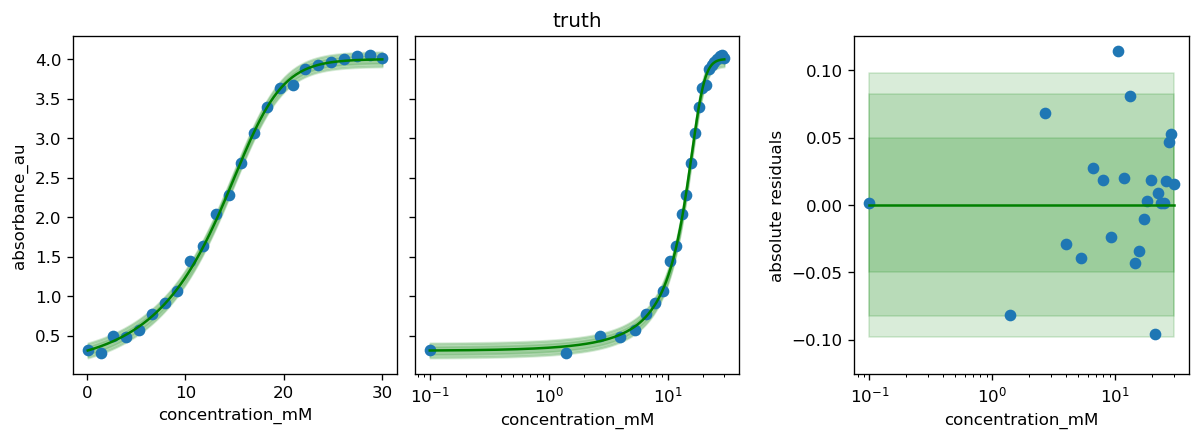

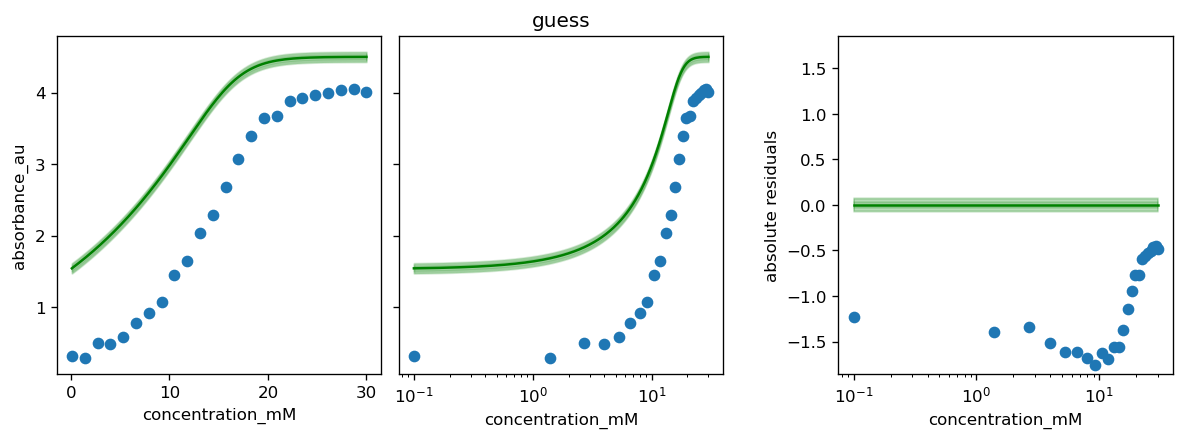

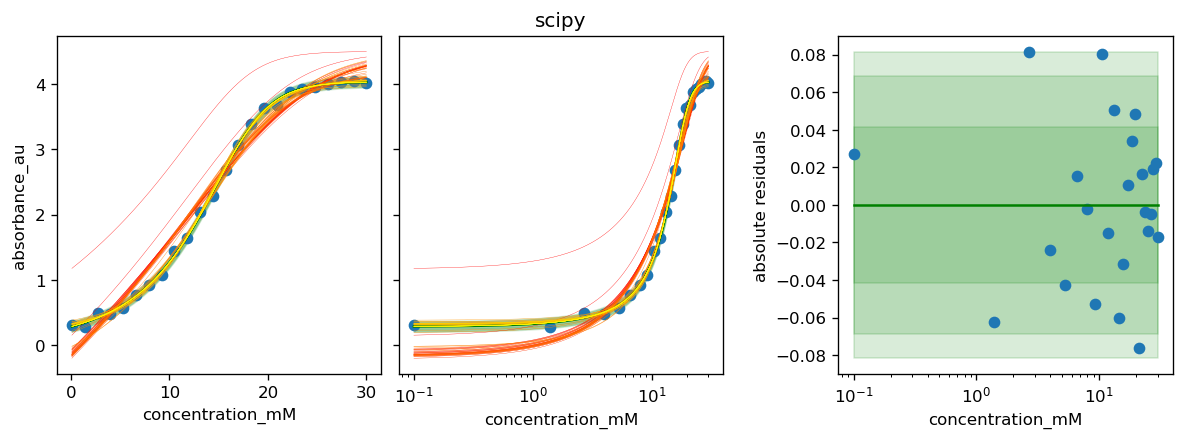

In [36]:
def plot_fit_history(axs, model, history):
    X = model.cal_independent
    for i, x in enumerate(history):
        x_dense = numpy.exp(numpy.linspace(numpy.log(min(X)), numpy.log(max(X)), 1000))
        mu, _ = model.predict_dependent(x_dense, theta=x)
        axs[0].plot(x_dense, mu, color=pyplot.cm.autumn(i / len(history)), linewidth=0.2)
        axs[1].plot(x_dense, mu, color=pyplot.cm.autumn(i / len(history)), linewidth=0.2)
    return


for method, history in zip(df_results.index, [None, None, history_scipy]):
    # the plot_model method uses model.theta_fitted
    # here we override it with the parameter set found by a certain method
    model.theta_fitted = df_results.loc[method, 'θ']
    
    fig, axs = calibr8.plot_model(model)
    if history is not None:
        plot_fit_history(axs, model, history)
    axs[1].set_title(method)
    fig.tight_layout()
    pyplot.show()

In [37]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Dec 13 2022

Python implementation: CPython
Python version       : 3.9.15
IPython version      : 8.7.0

sys       : 3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]
pandas    : 1.4.3
scipy     : 1.9.0
numpy     : 1.23.1
matplotlib: 3.5.3
calibr8   : 6.6.1

Watermark: 2.3.1

